In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c anaconda xlrd --yes

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes #
import folium # map rendering library

!conda install -c conda-forge wikipedia --yes
import wikipedia as wp
!pip install lxml

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

In [10]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import folium 
import wikipedia as wp
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

## Transform the data in the table on the Wikipedia page into the pandas dataframe.

In [11]:
url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

r = requests.get(url)

tables = pd.read_html(r.text)

In [12]:
df=pd.DataFrame(tables[0])

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

df.columns=['PostalCode','Borough','Neighbourhood']

df.drop([0],axis=0,inplace=True)
df.shape

(179, 3)

In [13]:
df.drop(df[df['Borough']=="Not assigned"].index,axis=0, inplace=True)

df1=df.groupby(['PostalCode'], as_index=False).agg(lambda x: ','.join(x))

df1.loc[df1['Neighbourhood']=="Not assigned",'Neighbourhood']=df1.loc[df1['Neighbourhood']=="Not assigned",'Borough']

df1.shape

(103, 3)

In [14]:
df1 = df1.replace(to_replace= r'\/', value= ',', regex=True)
df1.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Get the latitude and the longitude coordinates of each neighborhood.

In [15]:
df2=pd.read_csv('http://cocl.us/Geospatial_data')
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [16]:
df2.rename(index=str, columns={"Postal Code": "PostalCode"}, inplace = True)
df_toronto=pd.merge(df1, df2, on='PostalCode', how='inner')

In [17]:
df_toronto.rename(index=str, columns={"Neighbourhood": "Neighborhood"}, inplace = True)

In [18]:
df_toronto.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Get the population under each postal code.

In [19]:
url1="https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0"

r1 = requests.get(url1)

tables1 = pd.read_html(r1.text)

In [20]:
dfp=pd.DataFrame(tables1[0])

# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood

dfp.columns=['Geographic name','Population, 2016','extra1','extra2']

dfp.drop([0],axis=0,inplace=True)
dfp.shape

(1642, 4)

In [21]:
dfp.drop(columns={'extra1','extra2'},inplace=True)
dfp.head()
dfpop=dfp[dfp['Geographic name'].str.startswith('M')]
dfpop.rename(columns={'Geographic name':'PostalCode'},inplace=True)
dfpop.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PostalCode,"Population, 2016"
896,M1B,66108.0
897,M1C,35626.0
898,M1E,46943.0
899,M1G,29690.0
900,M1H,24383.0


## Merge population dataframe and toronto coordinates dataframe on PostalCode

In [41]:
df_toronto_pop=pd.merge(df_toronto, dfpop, on='PostalCode', how='inner')
df_toronto_pop.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016"
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,66108.0
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,35626.0
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711,46943.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383.0


In [40]:
df_toronto_pop.shape

(102, 6)

## Explore and cluster the neighborhoods in Toronto.

In [24]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [18]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
#map_toronto

In [44]:
tor_geo = r'Toronto2.geojson'
threshold_scale = np.linspace(df_toronto_pop['Population, 2016'].min(),
                              df_toronto_pop['Population, 2016'].max(),
                              6, dtype=float)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum population

# let Folium determine the scale.
tor_map = folium.Map(location=[43.6534817, -79.3839347], zoom_start=10)
tor_map.choropleth(
    geo_data=tor_geo,
    data=df_toronto_pop,
    columns=['PostalCode','Population, 2016'],
    key_on='feature.properties.CFSAUID',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Toronto Neighborhood Population Spread'
)
tor_map

In [45]:
CLIENT_ID = 'QW05TFN3S0LVNBRUMAWBAWBXXEUQSQGAAKJH0V0NYEJMEE0O' # your Foursquare ID
CLIENT_SECRET = 'QLGEKRSIDWK45FOYXDUXNES243NJ5VGR5SIQ1BVLYT4TSPOW' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QW05TFN3S0LVNBRUMAWBAWBXXEUQSQGAAKJH0V0NYEJMEE0O
CLIENT_SECRET:QLGEKRSIDWK45FOYXDUXNES243NJ5VGR5SIQ1BVLYT4TSPOW


In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [48]:
LIMIT=100
toronto_venues = getNearbyVenues(names=df_toronto_pop['Neighborhood'],
                                   latitudes=df_toronto_pop['Latitude'],
                                   longitudes=df_toronto_pop['Longitude']
                                  )
toronto_venues.head()

Malvern , Rouge
Rouge Hill , Port Union , Highland Creek
Guildwood , Morningside , West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park , Ionview , East Birchmount Park
Golden Mile , Clairlea , Oakridge
Cliffside , Cliffcrest , Scarborough Village West
Birch Cliff , Cliffside West
Dorset Park , Wexford Heights , Scarborough Town Centre
Wexford , Maryvale
Agincourt
Clarks Corners , Tam O'Shanter , Sullivan
Milliken , Agincourt North , Steeles East , L'Amoreaux East
Steeles West , L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview , Henry Farm , Oriole
Bayview Village
York Mills , Silver Hills
Willowdale , Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor , Wilson Heights , Downsview North
Northwood Park , York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill , Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West , Riverdale
India Bazaar , The Beaches 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern , Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood , Morningside , West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood , Morningside , West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood , Morningside , West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [49]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood , Long Branch",8,8,8,8,8,8
"Bathurst Manor , Wilson Heights , Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park , Lawrence Manor East",22,22,22,22,22,22
Berczy Park,55,55,55,55,55,55
"Birch Cliff , Cliffside West",4,4,4,4,4,4
"Brockton , Parkdale Village , Exhibition Place",24,24,24,24,24,24
Business reply mail Processing CentrE,16,16,16,16,16,16


In [50]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hospital,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [51]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped
toronto_grouped.shape

(92, 262)

In [53]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0  Latin American Restaurant  0.25
1               Skating Rink  0.25
2                     Lounge  0.25
3             Breakfast Spot  0.25
4         Miscellaneous Shop  0.00


----Alderwood , Long Branch----
            venue  freq
0     Pizza Place  0.25
1    Skating Rink  0.12
2  Sandwich Place  0.12
3             Gym  0.12
4             Pub  0.12


----Bathurst Manor , Wilson Heights , Downsview North----
           venue  freq
0           Bank  0.09
1    Coffee Shop  0.09
2          Diner  0.05
3    Gas Station  0.05
4  Shopping Mall  0.05


----Bayview Village----
                 venue  freq
0                 Café  0.25
1                 Bank  0.25
2  Japanese Restaurant  0.25
3   Chinese Restaurant  0.25
4          Yoga Studio  0.00


----Bedford Park , Lawrence Manor East----
                venue  freq
0          Restaurant  0.09
1  Italian Restaurant  0.09
2      Sandwich Place  0.09
3         Coffee Shop  0.09
4         P

## Since my customer is interested in Yoga Studio business. Lets find a location that is far from current Yoga Studios and highly populated.

In [72]:
toronto_part = toronto_grouped[['Neighborhood', 'Yoga Studio']]
#toronto_part

In [73]:
toronto_merged = pd.merge(df_toronto_pop, toronto_part, on='Neighborhood')
#toronto_merged

### This plot helps in identifying the boroughs with densely populated Indian restaurants and grocery.

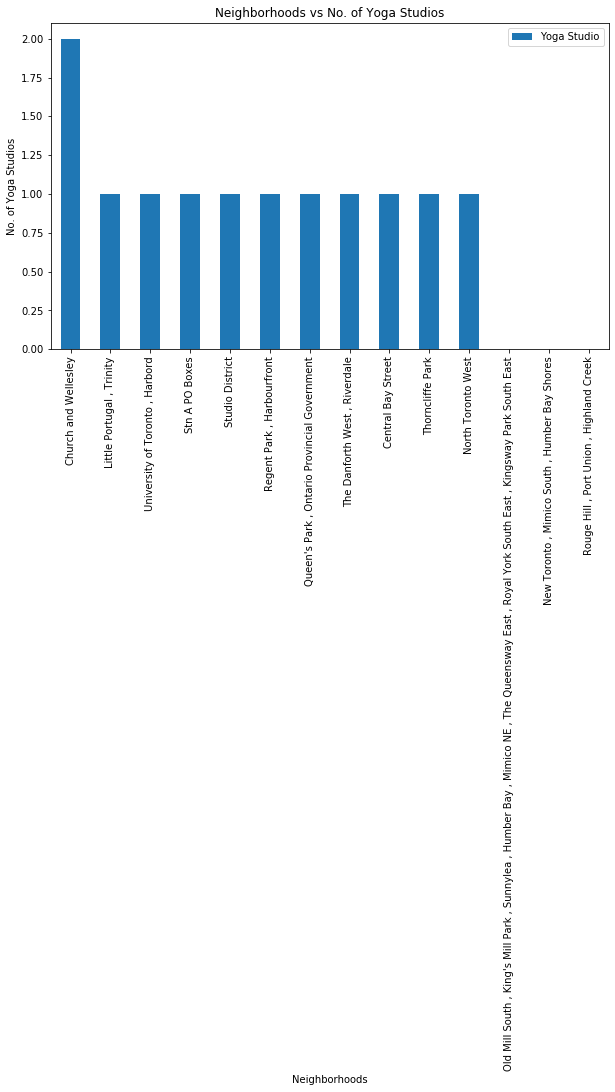

In [74]:
import matplotlib.pyplot as plt
graph = pd.DataFrame(toronto_onehot.groupby('Neighborhood')['Yoga Studio'].sum())
graph = graph.sort_values(by ='Yoga Studio', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("No. of Yoga Studios")
plt.title("Neighborhoods vs No. of Yoga Studios")
plt.show()

Thus this marks end of the data cleaning & analyses step in this project. Next we will look into the predictive modeling. In the predictive modelling we are going to use Clustering techniques since this is analysis of unlabelled data. K-Means clustering is used to perform the analysis of the data at hand.

## clustering

First step in K-means clustering is to identify best K value meaning the number of clusters in a given dataset. To do so we are going to use the elbow method on the Toronto dataset (i.e. toronto_merged dataframe).

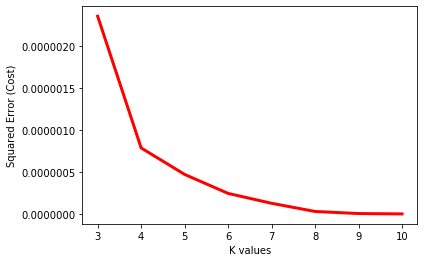

In [75]:
from sklearn.cluster import KMeans

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)


error_cost = []

for i in range(3,11):
    KM = KMeans(n_clusters = i, max_iter = 100)
    try:
        KM.fit(toronto_part_clustering)
    except ValueError:
        print("error on line",i)
    
    
    
    
    #calculate squared error for the clustered points
    error_cost.append(KM.inertia_/100)

#plot the K values aganist the squared error cost
plt.plot(range(3,11), error_cost, color='r', linewidth='3')
plt.xlabel('K values')
plt.ylabel('Squared Error (Cost)')
plt.grid(color='white', linestyle='-', linewidth=2)
plt.show()

After analysing using elbow method using distortion score & Squared error for each K value, looks like K = 4 is the best value.¶
Clustering the Toronto Neighborhood Using K-Means with K = 4

In [76]:
kclusters = 4

toronto_part_clustering = toronto_part.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_part_clustering)

kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [77]:
#sorted_neighborhoods_venues.drop(['Cluster Labels'],axis=1,inplace=True)
toronto_part.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = df_toronto_pop
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_part.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)
toronto_merged.reset_index(drop=True, inplace=True)
toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Cluster Labels,Yoga Studio
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,66108.0,0.0,0.0
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,35626.0,0.0,0.0
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711,46943.0,0.0,0.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690.0,0.0,0.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383.0,0.0,0.0


In [78]:
import matplotlib.cm as cm
import matplotlib.colors as colors

#map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11, width='90%', height='70%')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tor_map)
tor_map

Let us see the clusters visually on the map with the help of Folium.

## Examing the Clusters:

In [79]:
#Cluster 0
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Cluster Labels,Yoga Studio
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353,66108.0,0.0,0.0
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497,35626.0,0.0,0.0
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711,46943.0,0.0,0.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690.0,0.0,0.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383.0,0.0,0.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,36699.0,0.0,0.0
6,M1K,Scarborough,"Kennedy Park , Ionview , East Birchmount Park",43.727929,-79.262029,48434.0,0.0,0.0
7,M1L,Scarborough,"Golden Mile , Clairlea , Oakridge",43.711112,-79.284577,35081.0,0.0,0.0
8,M1M,Scarborough,"Cliffside , Cliffcrest , Scarborough Village West",43.716316,-79.239476,22913.0,0.0,0.0
9,M1N,Scarborough,"Birch Cliff , Cliffside West",43.692657,-79.264848,22136.0,0.0,0.0


In [67]:
#Cluster 1
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Yoga Studio
39,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188,1.0,0.023810
41,M4M,East Toronto,Studio District,43.659526,-79.340923,1.0,0.025000
50,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1.0,0.025974
51,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,1.0,0.021277
64,M5S,Downtown Toronto,"University of Toronto , Harbord",43.662696,-79.400049,1.0,0.028571
75,M6J,West Toronto,"Little Portugal , Trinity",43.647927,-79.419750,1.0,0.024390
83,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494,1.0,0.025641


In [80]:
#Cluster 2
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Cluster Labels,Yoga Studio
37,M4H,East York,Thorncliffe Park,43.705369,-79.349372,19688.0,2.0,0.047619
44,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,11394.0,2.0,0.055556


In [81]:
#Cluster 3
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,"Population, 2016",Cluster Labels,Yoga Studio
55,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,8423.0,3.0,0.016667
67,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,15.0,3.0,0.010753
